In [2]:
pip install psycopg2

  Obtaining dependency information for psycopg2 from https://files.pythonhosted.org/packages/33/39/5a9a229bb5414abeb86e33b8fc8143ab0aecce5a7f698a53e31367d30caa/psycopg2-2.9.10-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 487.6 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.2 MB 1.3 MB/s eta 0:00:01
   --------------------------------- ------ 1.0/1.2 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# notebooks/01_exploratory_data_analysis.ipynb

# Import necessary libraries
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

# --- Database Configuration (same as in database_loader.py) ---
# IMPORTANT: Replace with your actual PostgreSQL credentials
DB_USER = 'subway_user' # Or 'postgres'
DB_PASSWORD = '12345678' # Replace with your password
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'nyc_subway_db'

DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Create SQLAlchemy engine
try:
    engine = create_engine(DATABASE_URL)
    # Test connection
    with engine.connect() as connection:
        connection.execute(text("SELECT 1"))
    print("Successfully connected to the database.")
except Exception as e:
    print(f"Error connecting to database: {e}")
    print("Please ensure PostgreSQL is running and your connection details are correct.")
    engine = None # Set engine to None if connection fails

# --- Load Data from Database ---
# It's usually good to limit the data you load for initial EDA if the table is huge,
# but for ~5 million rows, loading the whole thing might be fine if you have enough RAM.
# If you run into memory issues, you can load a sample or filter by date.

if engine:
    try:
        print("Loading data from 'hourly_ridership' table...")
        # Using a direct SQL query to load data
        df = pd.read_sql_table('hourly_ridership', engine)
        
        # --- Post-load type conversion (if to_sql changed types or for consistency) ---
        # Ensure datetime columns are proper datetime objects
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        df['date'] = pd.to_datetime(df['date'])

        # Ensure categorical columns are actual categories for better performance/plotting
        for col in ['station_name', 'borough', 'day_of_week_name', 'month_name']:
            if col in df.columns:
                df[col] = df[col].astype('category')
        
        # Ensure numeric columns are optimal
        df['station_id'] = df['station_id'].astype('int32')
        df['hourly_ridership_total'] = df['hourly_ridership_total'].astype('int32')
        df['hour'] = df['hour'].astype('int8')
        df['day_of_week_num'] = df['day_of_week_num'].astype('int8')
        df['month'] = df['month'].astype('int8')
        df['year'] = df['year'].astype('int16')
        df['is_weekend'] = df['is_weekend'].astype('bool')
        df['is_am_rush'] = df['is_am_rush'].astype('bool')
        df['is_pm_rush'] = df['is_pm_rush'].astype('bool')


        print(f"Data loaded successfully. Shape: {df.shape}")
        print("\n--- DataFrame Info ---")
        df.info()
        print("\n--- Head of DataFrame ---")
        print(df.head())
    except Exception as e:
        print(f"Error loading data from database: {e}")
        df = pd.DataFrame() # Create empty DataFrame on error
else:
    df = pd.DataFrame() # Create empty DataFrame if engine wasn't created

Successfully connected to the database.
Loading data from 'hourly_ridership' table...
Data loaded successfully. Shape: (7972536, 22)

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972536 entries, 0 to 7972535
Data columns (total 22 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   transit_timestamp       datetime64[ns]
 1   transit_mode            object        
 2   station_id              int32         
 3   station_name            category      
 4   borough                 category      
 5   payment_method          object        
 6   fare_class_category     object        
 7   hourly_ridership_total  int32         
 8   transfers               float64       
 9   latitude                float64       
 10  longitude               float64       
 11  georeference            object        
 12  date                    datetime64[ns]
 13  hour                    int8          
 14  day_of_week_num      

In [2]:
# Example 1: Total Daily Ridership
if not df.empty:
    daily_ridership = df.groupby('date')['hourly_ridership_total'].sum().reset_index()
    daily_ridership['date'] = pd.to_datetime(daily_ridership['date']) # Ensure it's datetime for plotting

    fig = px.line(daily_ridership, x='date', y='hourly_ridership_total', 
                  title='Total Daily NYC Subway Ridership (Jan 2024 - Present)',
                  labels={'hourly_ridership_total': 'Total Ridership'})
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

In [3]:
# Example 2: Average Ridership by Day of Week
if not df.empty:
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    avg_ridership_day = df.groupby('day_of_week_name')['hourly_ridership_total'].mean().reindex(day_order).reset_index()

    fig = px.bar(avg_ridership_day, x='day_of_week_name', y='hourly_ridership_total',
                 title='Average Hourly Ridership by Day of Week',
                 labels={'hourly_ridership_total': 'Average Hourly Ridership', 'day_of_week_name': 'Day of Week'})
    fig.show()

In [4]:
# Example 3: Average Hourly Ridership throughout the Day
if not df.empty:
    avg_ridership_hour = df.groupby('hour')['hourly_ridership_total'].mean().reset_index()

    fig = px.line(avg_ridership_hour, x='hour', y='hourly_ridership_total',
                  title='Average Hourly Ridership Across All Stations',
                  labels={'hourly_ridership_total': 'Average Hourly Ridership', 'hour': 'Hour of Day (0-23)'})
    fig.update_traces(mode='lines+markers')
    fig.show()

In [5]:
# Example 4: Top 10 Busiest Stations (Total Ridership)
if not df.empty:
    top_stations = df.groupby('station_name')['hourly_ridership_total'].sum().nlargest(10).reset_index()

    fig = px.bar(top_stations, x='hourly_ridership_total', y='station_name', orientation='h',
                 title='Top 10 Busiest NYC Subway Stations (Total Ridership)',
                 labels={'hourly_ridership_total': 'Total Ridership', 'station_name': 'Station Name'})
    fig.update_layout(yaxis_categoryorder='total ascending') # Order from smallest to largest
    fig.show()

In [6]:
# Example 5: Hourly Ridership Heatmap for a Busiest Station (CORRECTED)
import plotly.graph_objects as go # We need to import graph_objects

if not df.empty:
    # Get the name of the busiest station (re-calculate if needed, or use a known one)
    busiest_station_name = df.groupby('station_name')['hourly_ridership_total'].sum().idxmax()
    
    station_df = df[df['station_name'] == busiest_station_name].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    # Aggregate hourly ridership for this station by day and hour
    station_hourly_pivot = station_df.pivot_table(
        index='hour', 
        columns='day_of_week_name', 
        values='hourly_ridership_total', 
        aggfunc='mean'
    )
    
    # Ensure columns are in correct day order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    station_hourly_pivot = station_hourly_pivot.reindex(columns=day_order)
    
    # --- CORRECTED HEATMAP GENERATION ---
    fig = go.Figure(data=go.Heatmap(
        z=station_hourly_pivot.values,
        x=station_hourly_pivot.columns,
        y=station_hourly_pivot.index,
        colorscale='Viridis' # You can choose other colorscales like 'Plasma', 'Jet', 'RdBu', etc.
    ))
    
    fig.update_layout(
        title=f'Average Hourly Ridership Heatmap for {busiest_station_name}',
        xaxis_title='Day of Week',
        yaxis_title='Hour of Day'
    )
    fig.show()

In [7]:
# Example 6: Total Ridership by Borough
if not df.empty:
    ridership_by_borough = df.groupby('borough')['hourly_ridership_total'].sum().reset_index()

    fig = px.bar(ridership_by_borough, x='borough', y='hourly_ridership_total',
                 title='Total NYC Subway Ridership by Borough',
                 labels={'hourly_ridership_total': 'Total Ridership'})
    fig.show()

# Next Step Forecasting

In [8]:
# Assuming you have the 'df' DataFrame loaded from the previous steps in your notebook

# --- Prepare data for Prophet ---
# 1. Aggregate hourly ridership to daily total ridership
daily_ridership_for_prophet = df.groupby('date')['hourly_ridership_total'].sum().reset_index()

# 2. Rename columns to 'ds' and 'y' as required by Prophet
daily_ridership_for_prophet.rename(columns={'date': 'ds', 'hourly_ridership_total': 'y'}, inplace=True)

# Ensure 'ds' is a datetime object (it should be if you followed data_cleaning, but double check)
daily_ridership_for_prophet['ds'] = pd.to_datetime(daily_ridership_for_prophet['ds'])

print("Data prepared for Prophet:")
print(daily_ridership_for_prophet.head())
print(daily_ridership_for_prophet.tail())
print(f"Prophet data shape: {daily_ridership_for_prophet.shape}")

Data prepared for Prophet:
          ds       y
0 2020-07-02  373474
1 2020-07-03     208
2 2020-07-05       7
3 2020-07-06  624728
4 2020-07-09  735684
             ds        y
1101 2024-12-25     3824
1102 2024-12-27      338
1103 2024-12-28     5288
1104 2024-12-29     7587
1105 2024-12-30  3460500
Prophet data shape: (1106, 2)


In [12]:
pip install prophet


  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c7/ef/925617d36c08e0bbdf4347a9b38974ce7ab8fdb5d1a5cf0e3f3c65ea43da/prophet-1.1.7-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/19/d0/ba795addc22473f033883f2d2048a573a414c24d4f47399090daa9fcf977/holidays-0.74-py3-none-any.whl.metadata
  Obtaining dependency information for importlib_resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed

In [9]:
# Import Prophet
from prophet import Prophet

# Create a Prophet model instance
# You can add parameters here to handle specific seasonality (e.g., weekly_seasonality=True, daily_seasonality=True)
# Prophet automatically detects daily, weekly, and yearly seasonality by default if data is sufficient.
# We'll explicitly add weekly and yearly seasonality, and custom daily if we think it's strong.
m = Prophet(
    daily_seasonality=False, # We have hourly data, so daily patterns are aggregated out for daily sums.
                             # If we were forecasting *hourly* data, this would be True.
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive', # Can also be 'multiplicative' for trends that grow proportionally
    changepoint_prior_scale=0.05 # Adjusts flexibility of trend changes (higher = more flexible)
)

# Add New York City holidays (optional, but highly recommended for better accuracy)
# Holidays can significantly impact ridership. Prophet has a built-in holidays feature.
# You can define a custom DataFrame for holidays.
# Example: https://github.com/facebook/prophet/blob/main/python/examples/holidays.py
ny_holidays = pd.DataFrame([
    {'holiday': 'New Year\'s Day', 'ds': '2024-01-01', 'lower_window': 0, 'upper_window': 1},
    {'holiday': 'MLK Day', 'ds': '2024-01-15', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Presidents\' Day', 'ds': '2024-02-19', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Memorial Day', 'ds': '2024-05-27', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Juneteenth', 'ds': '2024-06-19', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Independence Day', 'ds': '2024-07-04', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Labor Day', 'ds': '2024-09-02', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Columbus Day', 'ds': '2024-10-14', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Veterans Day', 'ds': '2024-11-11', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Thanksgiving Day', 'ds': '2024-11-28', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Christmas Day', 'ds': '2024-12-25', 'lower_window': 0, 'upper_window': 1},
    # Add holidays for 2025 as well, extending as far as your data goes or forecast
    {'holiday': 'New Year\'s Day', 'ds': '2025-01-01', 'lower_window': 0, 'upper_window': 1},
    {'holiday': 'MLK Day', 'ds': '2025-01-20', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Presidents\' Day', 'ds': '2025-02-17', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Memorial Day', 'ds': '2025-05-26', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Juneteenth', 'ds': '2025-06-19', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Independence Day', 'ds': '2025-07-04', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Labor Day', 'ds': '2025-09-01', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Columbus Day', 'ds': '2025-10-13', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Veterans Day', 'ds': '2025-11-11', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Thanksgiving Day', 'ds': '2025-11-27', 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'Christmas Day', 'ds': '2025-12-25', 'lower_window': 0, 'upper_window': 1},
    # And so on for future years if you want to forecast beyond Dec 2025
])
m.add_country_holidays(country_name='US') # Uses built-in US holidays (ensure you also add state/city specific if very important)
# Or for more custom control and potentially better accuracy based on NYC's specific observance:
# m.add_holiday(ny_holidays)

# Fit the model to your historical daily ridership data
print("Training Prophet model...")
m.fit(daily_ridership_for_prophet)
print("Model training complete.")

Training Prophet model...


13:59:30 - cmdstanpy - INFO - Chain [1] start processing
13:59:31 - cmdstanpy - INFO - Chain [1] done processing


Model training complete.


In [10]:
# Define how many future periods (days) to forecast
future_days = 90 # Forecast for the next 90 days (approx 3 months)

# Create a DataFrame with future dates
future = m.make_future_dataframe(periods=future_days)

print(f"Future DataFrame created with {len(future)} dates, extending to: {future.tail()}")

# Make predictions
forecast = m.predict(future)

print("Forecast generated:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Future DataFrame created with 1196 dates, extending to:              ds
1191 2025-03-26
1192 2025-03-27
1193 2025-03-28
1194 2025-03-29
1195 2025-03-30
Forecast generated:
             ds           yhat     yhat_lower    yhat_upper
1191 2025-03-26  323033.964704 -463507.090019  1.006691e+06
1192 2025-03-27  445151.559486 -351960.765290  1.209839e+06
1193 2025-03-28  290323.749988 -459494.961458  1.057313e+06
1194 2025-03-29  391581.335547 -432866.571179  1.182960e+06
1195 2025-03-30  324077.587623 -461803.587208  1.088497e+06


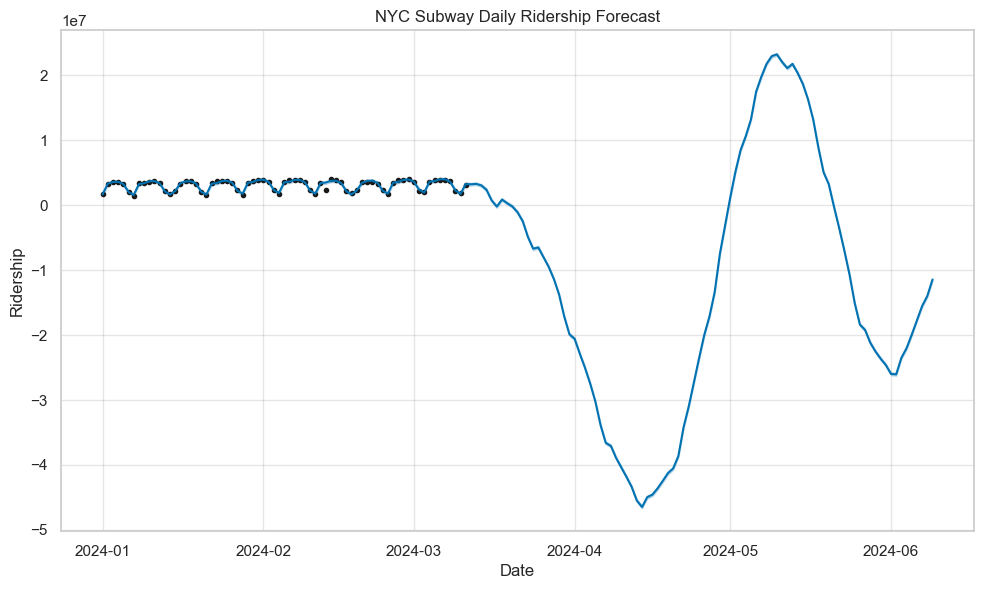

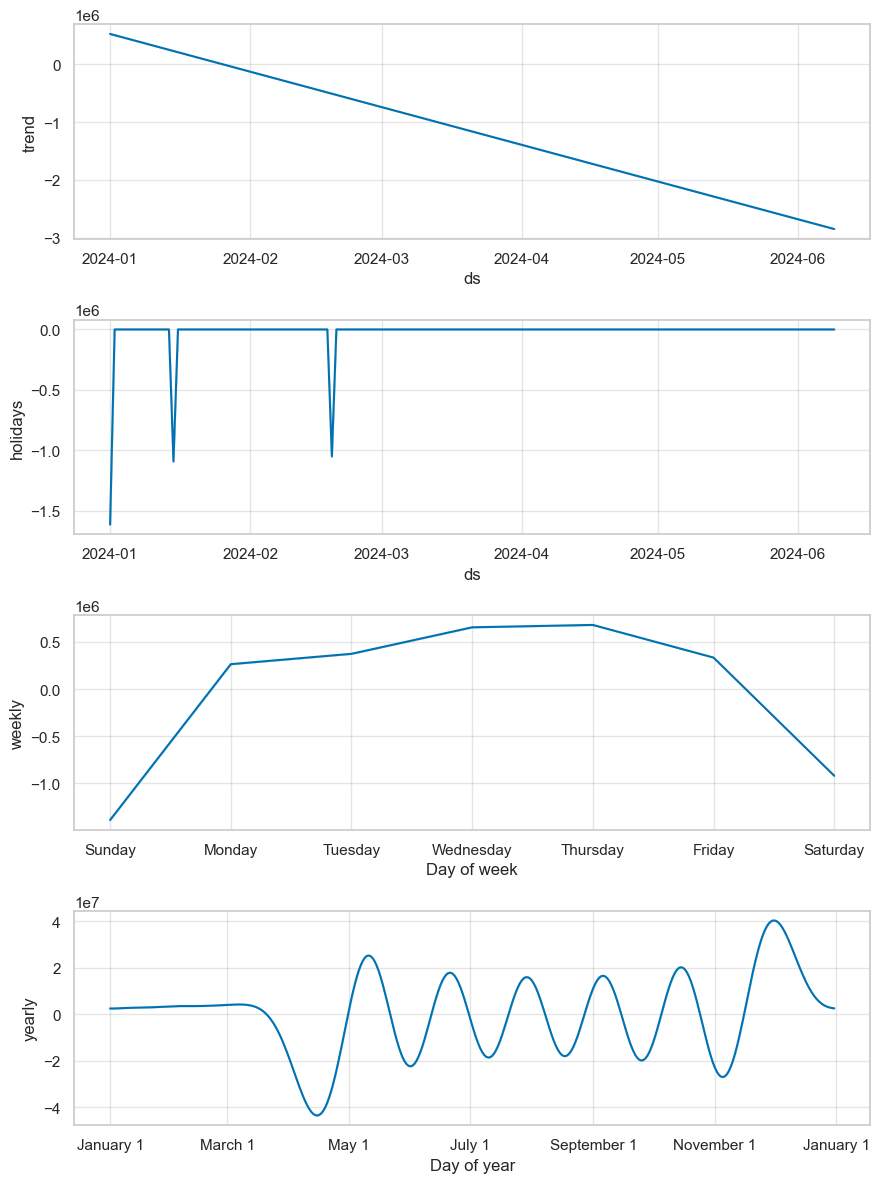

In [20]:
# Plot the forecast
fig1 = m.plot(forecast)
plt.title('NYC Subway Daily Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.show()

# Plot the components of the forecast (trend, weekly seasonality, yearly seasonality)
fig2 = m.plot_components(forecast)
plt.show()

Starting cross-validation (this can take a while for large datasets)...
Data duration: 1642 days 00:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

14:08:52 - cmdstanpy - INFO - Chain [1] start processing
14:08:52 - cmdstanpy - INFO - Chain [1] done processing
14:08:53 - cmdstanpy - INFO - Chain [1] start processing
14:08:53 - cmdstanpy - INFO - Chain [1] done processing
14:08:53 - cmdstanpy - INFO - Chain [1] start processing
14:08:53 - cmdstanpy - INFO - Chain [1] done processing
14:08:53 - cmdstanpy - INFO - Chain [1] start processing
14:08:53 - cmdstanpy - INFO - Chain [1] done processing
14:08:53 - cmdstanpy - INFO - Chain [1] start processing
14:08:53 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1]

Cross-validation complete.

Performance Metrics (e.g., MSE, RMSE, MAE):
  horizon           mse           rmse            mae         mape      mdape  \
0 10 days  4.768330e+11  690530.966692  464624.481686  1371.553716  39.431881   
1 11 days  4.580653e+11  676805.222982  478233.296400  1363.043911  39.431881   
2 12 days  4.928478e+11  702031.198120  499541.162813  1354.387339  40.544114   
3 13 days  4.817063e+11  694050.627264  492474.715846  1294.768926  40.515346   
4 14 days  4.649383e+11  681863.825638  478429.797956  1252.175757  36.524217   

      smape  coverage  
0  1.752592  0.830556  
1  1.750906  0.828889  
2  1.753776  0.827273  
3  1.756868  0.839394  
4  1.708145  0.850505  


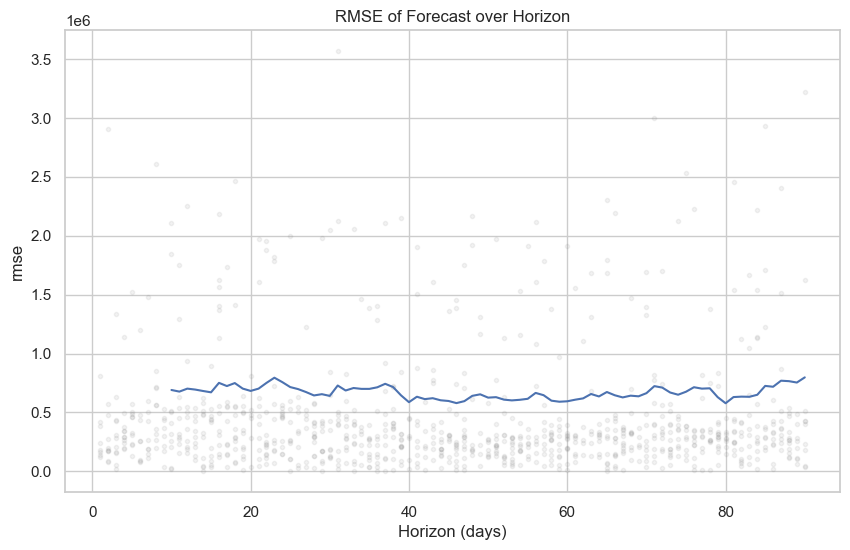

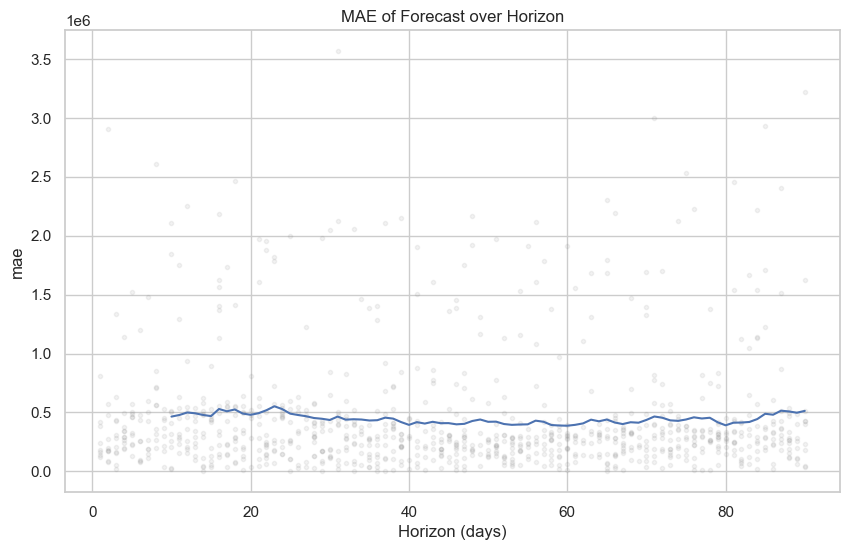

In [13]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import timedelta

print("Starting cross-validation (this can take a while for large datasets)...")
# initial: training period (e.g., 1 year)
# period: step size between cutoffs (e.g., 1 month)
# horizon: how far to forecast from each cutoff (e.g., 90 days)
# You need enough data for this. If your dataset starts Jan 2024 to June 2025, you have ~1.5 years.
# A good start would be to train on 1 year, and test on subsequent 3 months.
# Adjust these values based on your actual data duration.
# Example: initial = '365 days', period = '90 days', horizon = '90 days'
# Let's say your data runs from Jan 2024 to May 2025.
# `initial` should be at least 2x `horizon` if possible.
# Ensure `initial` is less than your total data duration.

# Get the duration of your data
data_duration = daily_ridership_for_prophet['ds'].max() - daily_ridership_for_prophet['ds'].min()
print(f"Data duration: {data_duration}")

# Adjust these based on your data duration to ensure enough data for initial training
# If your data is only a few months, cross-validation might not be feasible or meaningful.
# For 1.5 years of data (Jan 2024 - mid 2025), a 1-year initial and 90-day horizon is reasonable.
if data_duration > timedelta(days=365 + 90): # At least 1 year + 90 days for one CV run
    try:
        df_cv = cross_validation(
            m, 
            initial='366 days', # Train on first year of data
            period='90 days',   # Re-evaluate every 3 months
            horizon='90 days'   # Forecast 3 months ahead
        )
        print("Cross-validation complete.")
        
        df_p = performance_metrics(df_cv)
        print("\nPerformance Metrics (e.g., MSE, RMSE, MAE):")
        print(df_p.head())

        # Plot RMSE over forecast horizon
        fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')
        plt.title('RMSE of Forecast over Horizon')
        plt.show()
        
        # Plot MAE over forecast horizon
        fig_mae = plot_cross_validation_metric(df_cv, metric='mae')
        plt.title('MAE of Forecast over Horizon')
        plt.show()

    except Exception as e:
        print(f"Error during cross-validation: {e}")
        print("This often happens if your 'initial' period is too long for the available data,")
        print("or if there aren't enough data points for multiple cutoffs.")
        print("You may need to reduce 'initial', 'period', or 'horizon' values.")
        print("Alternatively, skip cross-validation for now if data range is limited.")
else:
    print("Not enough data for meaningful cross-validation with default parameters.")
    print("Consider collecting more historical data or skipping cross-validation for this project.")

In [14]:
from prophet.diagnostics import performance_metrics

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Display the performance metrics DataFrame
print("\nAggregated Performance Metrics:")
print(df_p.head()) # Display the first few rows of the performance metrics
print(df_p.tail()) # Display the last few rows to see longer horizons


Aggregated Performance Metrics:
  horizon           mse           rmse            mae         mape      mdape  \
0 10 days  4.768330e+11  690530.966692  464624.481686  1371.553716  39.431881   
1 11 days  4.580653e+11  676805.222982  478233.296400  1363.043911  39.431881   
2 12 days  4.928478e+11  702031.198120  499541.162813  1354.387339  40.544114   
3 13 days  4.817063e+11  694050.627264  492474.715846  1294.768926  40.515346   
4 14 days  4.649383e+11  681863.825638  478429.797956  1252.175757  36.524217   

      smape  coverage  
0  1.752592  0.830556  
1  1.750906  0.828889  
2  1.753776  0.827273  
3  1.756868  0.839394  
4  1.708145  0.850505  
   horizon           mse           rmse            mae        mape      mdape  \
76 86 days  5.156304e+11  718074.082340  480622.557995  724.451553  51.809181   
77 87 days  5.919689e+11  769395.173521  514640.787942  709.252876  53.943216   
78 88 days  5.859525e+11  765475.360109  508511.490684  628.588111  49.041409   
79 89 days  

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("RMSE vs. Horizon", "MAE vs. Horizon",
                                    "MAPE vs. Horizon", "Coverage vs. Horizon"))

# Add RMSE trace
fig.add_trace(go.Scatter(x=df_p['horizon'], y=df_p['rmse'], mode='lines+markers', name='RMSE'),
              row=1, col=1)
fig.update_yaxes(title_text="RMSE", row=1, col=1)

# Add MAE trace
fig.add_trace(go.Scatter(x=df_p['horizon'], y=df_p['mae'], mode='lines+markers', name='MAE'),
              row=1, col=2)
fig.update_yaxes(title_text="MAE", row=1, col=2)

# Add MAPE trace
fig.add_trace(go.Scatter(x=df_p['horizon'], y=df_p['mape'], mode='lines+markers', name='MAPE'),
              row=2, col=1)
fig.update_yaxes(title_text="MAPE", row=2, col=1)

# Add Coverage trace
fig.add_trace(go.Scatter(x=df_p['horizon'], y=df_p['coverage'], mode='lines+markers', name='Coverage'),
              row=2, col=2)
fig.update_yaxes(title_text="Coverage", range=[0, 1], row=2, col=2) # Coverage is a percentage

fig.update_layout(title_text="Prophet Cross-Validation Performance Metrics", height=800, showlegend=False)
fig.show()

In [16]:
# Create a DataFrame with future dates for forecasting
# Let's forecast for the next 90 days from the end of your historical data
future = m.make_future_dataframe(periods=90, freq='H') # 'H' for hourly frequency

# Make the forecast
forecast = m.predict(future)

# Display the head and tail of the forecast DataFrame
print("\nFuture Forecast (Head):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFuture Forecast (Tail):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


Future Forecast (Head):
          ds           yhat     yhat_lower     yhat_upper
0 2020-07-02  197824.055025 -546717.816057  967602.215085
1 2020-07-03   57727.152779 -685079.789120  866718.470010
2 2020-07-05   43147.127846 -766786.761798  827745.874294
3 2020-07-06   68960.857597 -690800.200715  847171.694263
4 2020-07-09  159825.129833 -594944.393488  880484.696130

Future Forecast (Tail):
                      ds           yhat     yhat_lower    yhat_upper
1191 2025-01-02 14:00:00  339288.951017 -400394.095847  1.105105e+06
1192 2025-01-02 15:00:00  330538.638410 -456102.474033  1.096767e+06
1193 2025-01-02 16:00:00  322016.486392 -471145.857702  1.145231e+06
1194 2025-01-02 17:00:00  313815.598706 -438175.635861  1.086098e+06
1195 2025-01-02 18:00:00  306024.957364 -458890.386880  1.057181e+06


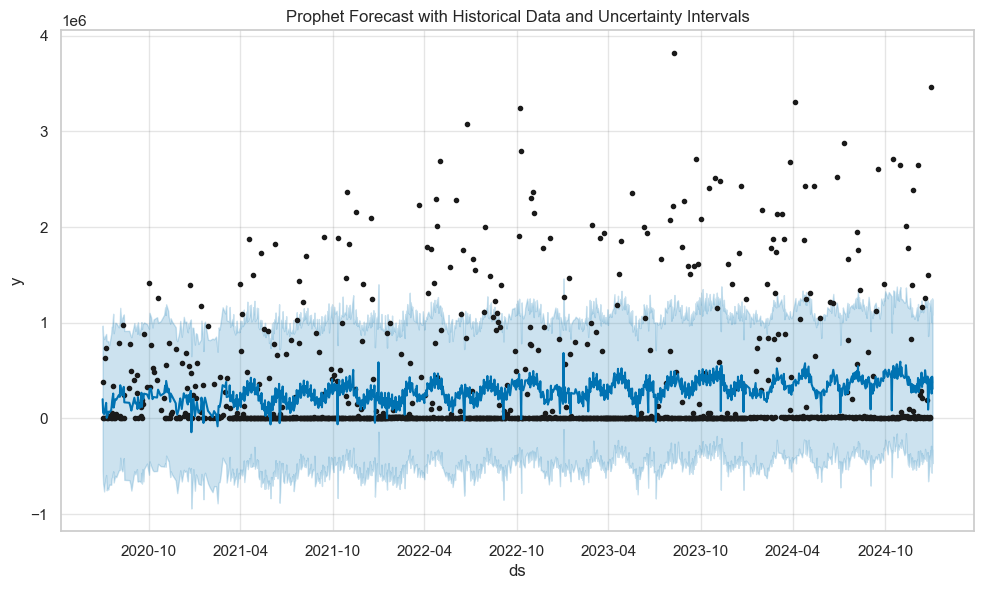

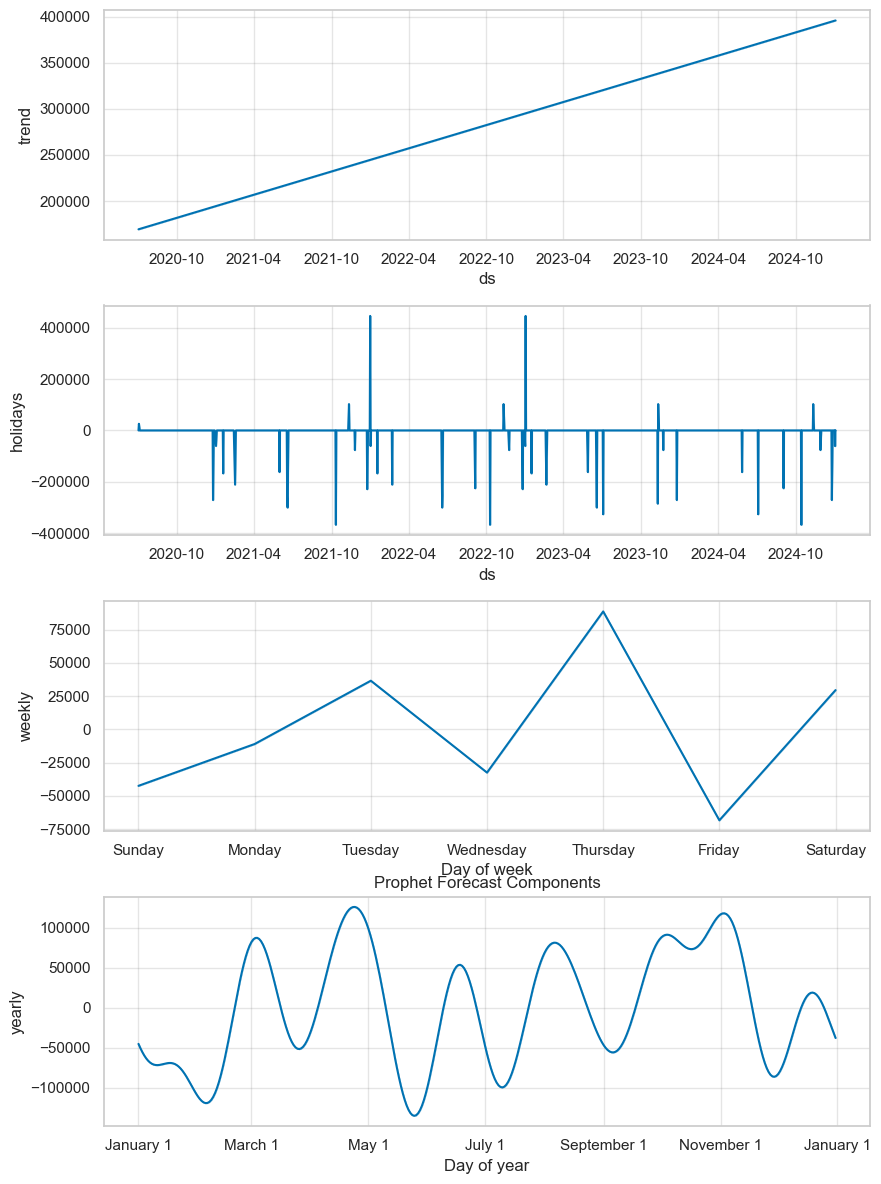

In [18]:
import matplotlib.pyplot as plt # Make sure this import is at the top of your notebook if it's not already there

# Plot the forecast
fig = m.plot(forecast)

# Add a title using Matplotlib's plt.title()
plt.title("Prophet Forecast with Historical Data and Uncertainty Intervals")
plt.show() # This ensures the plot is displayed if not automatically shown in your environment

# You can also plot components (trend, weekly, yearly seasonality)
fig_components = m.plot_components(forecast)
plt.title("Prophet Forecast Components") # Add title to components plot
plt.show() # Display components plot

In [19]:
import joblib
import os

# Define the path to save the model
model_save_path = 'models/prophet_ridership_model.pkl'

# Ensure the 'models' directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
joblib.dump(m, model_save_path)
print(f"Prophet model saved successfully to: {model_save_path}")

# You can load it back later if needed:
# loaded_model = joblib.load(model_save_path)
# print("Model loaded successfully.")

Prophet model saved successfully to: models/prophet_ridership_model.pkl


In [20]:
from sqlalchemy import create_engine
import os

# Database connection details (ensure these match your setup)
DB_USER = os.getenv('DB_USER', 'subway_user')
DB_PASSWORD = os.getenv('DB_PASSWORD', '12345678')
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')
DB_NAME = os.getenv('DB_NAME', 'nyc_subway_db')


DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Create the SQLAlchemy engine
engine = create_engine(DATABASE_URL)

# Prepare the forecast DataFrame for database loading
# Select relevant columns and ensure 'ds' is datetime
forecast_db = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_db.rename(columns={'ds': 'forecast_timestamp'}, inplace=True) # Rename for clarity in DB
forecast_db['forecast_timestamp'] = pd.to_datetime(forecast_db['forecast_timestamp'])

# Define the table name for forecasts
forecast_table_name = 'hourly_ridership_forecasts'

try:
    print(f"Loading forecast data into '{forecast_table_name}' table. This will REPLACE any existing forecasts.")
    # Use if_exists='replace' to ensure you always have the latest forecast
    forecast_db.to_sql(forecast_table_name, engine, if_exists='replace', index=False)
    
    print(f"Successfully loaded {len(forecast_db)} forecast rows into '{forecast_table_name}' table.")
    
    # Verify by checking row count in the database
    with engine.connect() as connection:
        count = connection.execute(f"SELECT COUNT(*) FROM {forecast_table_name}").scalar()
        print(f"Total rows in forecast table '{forecast_table_name}': {count}")

except Exception as e:
    print(f"An error occurred during forecast database loading: {e}")
    import traceback
    traceback.print_exc()

C:\Users\VADLAMUDI\AppData\Local\Temp\ipykernel_20680\2756199264.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\VADLAMUDI\AppData\Local\Temp\ipykernel_20680\2756199264.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Loading forecast data into 'hourly_ridership_forecasts' table. This will REPLACE any existing forecasts.
Successfully loaded 1196 forecast rows into 'hourly_ridership_forecasts' table.
Total rows in forecast table 'hourly_ridership_forecasts': 1196
